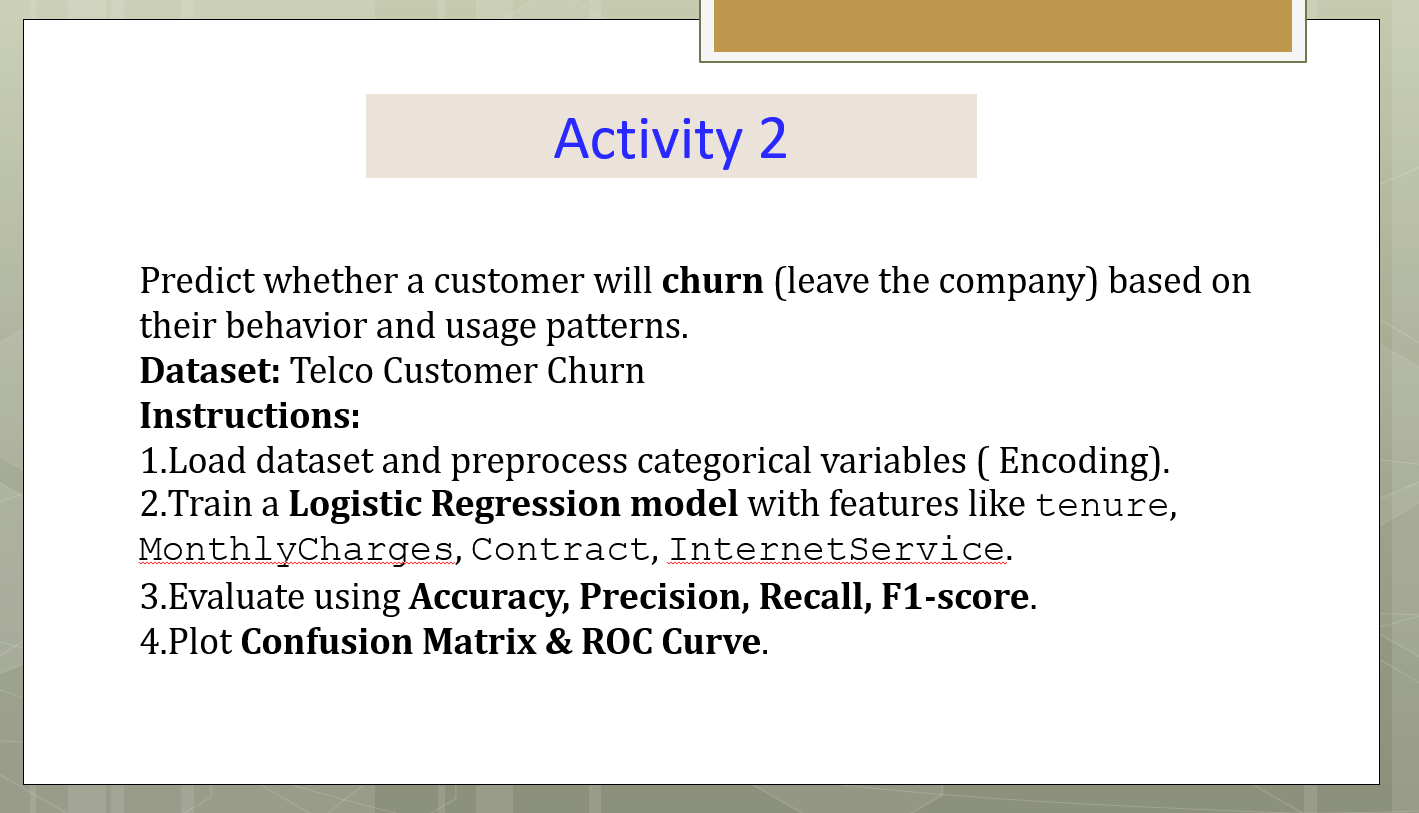


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np


# Data Loading


In [48]:
churn_data = pd.read_csv("Datasets/Telco Customer Churn.csv")
churn_data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [49]:
churn_data.shape

(7043, 21)

# Data Preprocessing


In [50]:
churn_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

- we have no missing values so no need to do anything here whatsoever


In [51]:
print(churn_data["Churn"].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [52]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

- lots of non int/float types so logistic regression won't work, gotta do one hot or label encoding on these. but first, should we just use all the columns (other then Churn) to try to predict Churn? can we get rid of some useless columns?
- well, we should separate our features and target first and get rid of customerID and target variable (Churn) from the features df


In [53]:
X = churn_data.drop(columns=["Churn", "customerID"])
y = churn_data["Churn"]

- now lets encode the variables and then try to perform feature selection (logically, it may seem that we should choose features first and then encode and so on, but thing is, we can't use any of the methods for feature selection without encoding, like even if you want a simple correlation matrix, you need to make your features non-categorical first)
- lets keep it simple, for nominal (no inherent ordering) we do one hot encoding, and for ordinal (there is an inherent order) we do label encoding


In [54]:
from sklearn.preprocessing import LabelEncoder

# gender is binary categorical, so label encoding is fine
le = LabelEncoder()
X["gender"] = le.fit_transform(X["gender"])
X.dtypes

gender                int64
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [55]:
# let me check possible values of partner and dependents and other columns now in order to determine if label encoding is fine for them too or we gotta try one hot
categorical_cols = X.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    print(f"\n{col}: {X[col].unique()}")
    print(f"Count: {len(X[col].unique())}")



Partner: ['Yes' 'No']
Count: 2

Dependents: ['No' 'Yes']
Count: 2

PhoneService: ['No' 'Yes']
Count: 2

MultipleLines: ['No phone service' 'No' 'Yes']
Count: 3

InternetService: ['DSL' 'Fiber optic' 'No']
Count: 3

OnlineSecurity: ['No' 'Yes' 'No internet service']
Count: 3

OnlineBackup: ['Yes' 'No' 'No internet service']
Count: 3

DeviceProtection: ['No' 'Yes' 'No internet service']
Count: 3

TechSupport: ['No' 'Yes' 'No internet service']
Count: 3

StreamingTV: ['No' 'Yes' 'No internet service']
Count: 3

StreamingMovies: ['No' 'Yes' 'No internet service']
Count: 3

Contract: ['Month-to-month' 'One year' 'Two year']
Count: 3

PaperlessBilling: ['Yes' 'No']
Count: 2

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Count: 4

TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Count: 6531


In [56]:
# partner, dependents, phone service, and paperless billing are all binary categorical, so label encoding is fine for them too
binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
for col in binary_cols:
    X[col] = le.fit_transform(X[col])
X.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [57]:
# all the other features had 3 values essentially, so one hot encoding is better for them
nominal_cols = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

X = pd.get_dummies(X, columns=nominal_cols, drop_first=True)
X.dtypes

gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                              object
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             bool
TechSupport_Yes     

In [58]:
# that leaves out only total charges which is actually a numerical feature with lots of unique values, so simple type casting should work here:
X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")
X.dtypes

gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             bool
TechSupport_Yes     

In [59]:
# looking at the above code, doing errors='coerce' will convert non-numeric values to NaN, so we need to handle those NaN values, if any
X.isnull().sum()

gender                                    0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
tenure                                    0
PhoneService                              0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
MultipleLines_No phone service            0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
InternetService_No                        0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                           0
StreamingTV_No internet service           0
StreamingTV_Yes                 

- as expected, we have 11 NaN values in TotalCharges, we can fill them with median or mean, we gotta use whichever better represents the "typical datapoint" or typical customer in our case. if data is skewed towards one side or has lots of outliers then that makes mean much less representative of the typical data point, hence we would choose median. we can see if the data is skewed or not by plotting a simple histogram


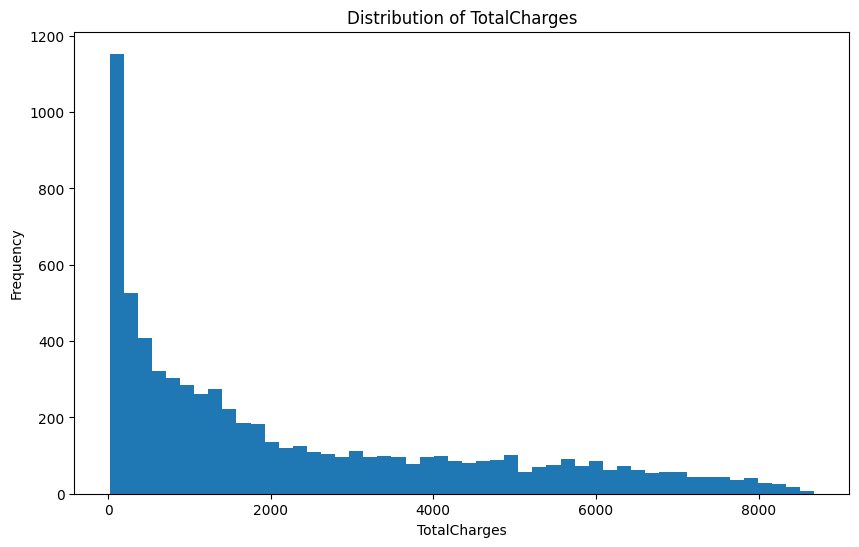

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(X["TotalCharges"], bins=50)
# plt.axvline(X['TotalCharges'].mean(), color='red', linestyle='--', label=f'Mean: {X["TotalCharges"].mean():.2f}')
# plt.axvline(X['TotalCharges'].median(), color='green', linestyle='-', label=f'Median: {X["TotalCharges"].median():.2f}')
# plt.legend()
plt.title("Distribution of TotalCharges")
plt.xlabel("TotalCharges")
plt.ylabel("Frequency")
plt.show()

- so its obviously skewed, to the left, as in almost all the customers have a very very low total cost, so median is what we will use here


In [61]:
X["TotalCharges"] = X["TotalCharges"].fillna(X["TotalCharges"].median())
X.isnull().sum()

gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV_Yes                          0
StreamingMo

In [62]:
# I forgot to encode the target variable y
y = le.fit_transform(y)
print(y)
print(le.inverse_transform([0, 1]))

[0 0 1 ... 0 1 0]
['No' 'Yes']


# Feature Selection


In [63]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
selected_features

Index(['tenure', 'InternetService_Fiber optic',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingMovies_No internet service', 'Contract_Two year',
       'PaymentMethod_Electronic check'],
      dtype='object')

In [64]:
X_selected_df = X[selected_features]
X_selected_df.head(5)

,tenure,InternetService_Fiber optic,OnlineSecurity_No internet service,OnlineBackup_No internet service,DeviceProtection_No internet service,TechSupport_No internet service,StreamingTV_No internet service,StreamingMovies_No internet service,Contract_Two year,PaymentMethod_Electronic check
0,1,False,False,False,False,False,False,False,False,True
1,34,False,False,False,False,False,False,False,False,False
2,2,False,False,False,False,False,False,False,False,False
3,45,False,False,False,False,False,False,False,False,False
4,2,True,False,False,False,False,False,False,False,True


In [65]:
print(X_selected_df.dtypes)
print(y.dtype)

tenure                                  int64
InternetService_Fiber optic              bool
OnlineSecurity_No internet service       bool
OnlineBackup_No internet service         bool
DeviceProtection_No internet service     bool
TechSupport_No internet service          bool
StreamingTV_No internet service          bool
StreamingMovies_No internet service      bool
Contract_Two year                        bool
PaymentMethod_Electronic check           bool
dtype: object
int64


In [66]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        z = np.array(z, dtype=np.float64)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features, dtype=np.float64)
        self.bias = 0.0

        for _ in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(z)

            dw = np.dot(X.T, (y_predicted - y)) / num_samples
            db = np.sum(y_predicted - y) / num_samples

            self.weights = self.weights - self.learning_rate * dw
            self.bias = self.bias - self.learning_rate * db

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        z = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(z)
        return (y_predicted > 0.5).astype(int)

In [67]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)

In [68]:
y_pred = model.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8027

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.68      0.47      0.56       373

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409


Confusion Matrix:
[[955  81]
 [197 176]]


---
---
---

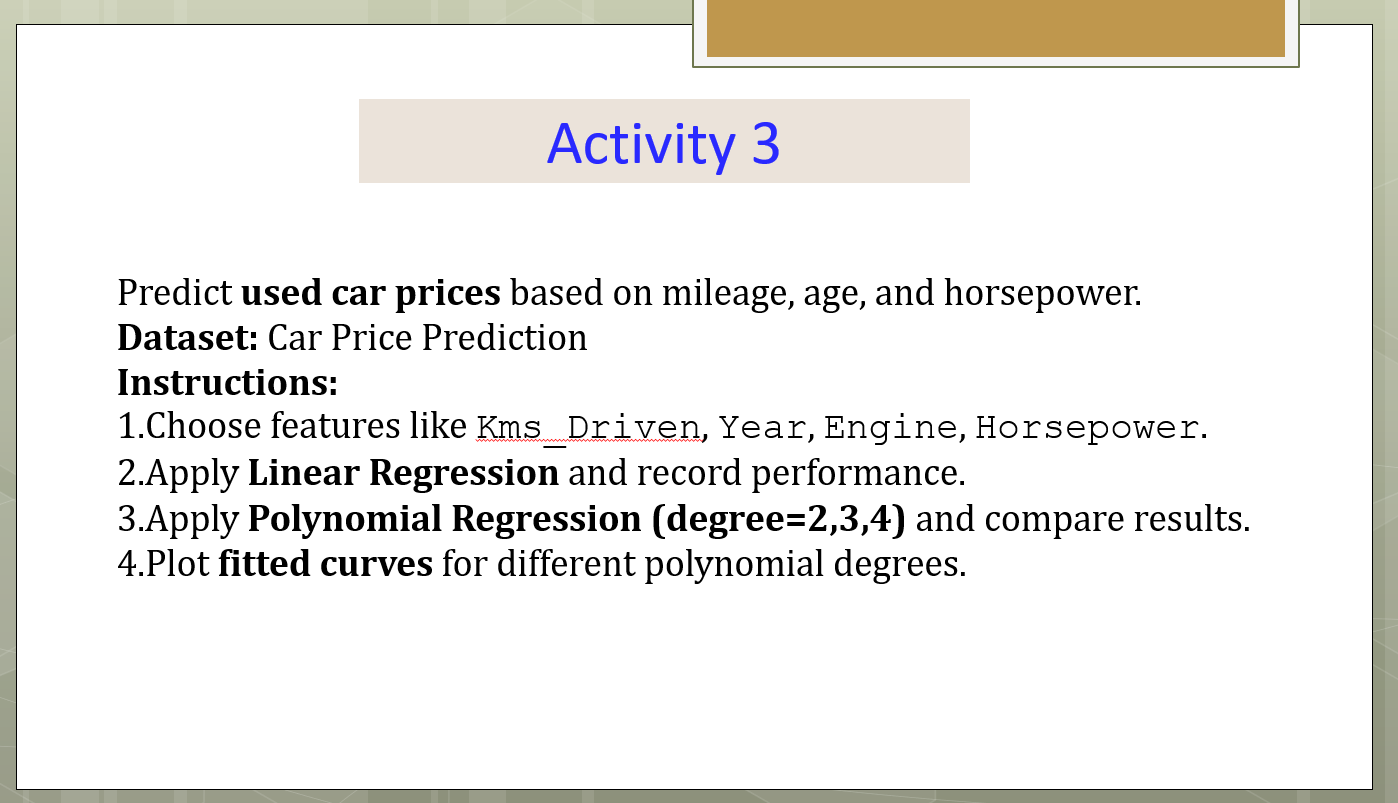

In [70]:
cars_df = pd.read_csv("Datasets/Car Price Prediction.csv")
cars_df.head(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [71]:
cars_df.shape

(205, 26)

- too tired to go for feature selection in this one so just ganna do exactly as instructed and choose the 4 features suggested in the activity (horsepower, engine, year, kms_driven)

In [72]:
cars_df.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

- ok well this is weird, out of the 4 features suggested in the activity, 3 don't even fricking exist in the df. weird
- I could use selectkbest and f_regression instead of f_classif or I could maybe draw out a correlation matrix to select feature.
- but who cares, I'm just ganna use intuition and select the features I think best predict the price

In [73]:
cars_df_X = cars_df[
    [
        "horsepower",
        "enginesize",
        "peakrpm",
        "carheight",
        "carwidth",
        "carlength",
        "stroke",
    ]
]
cars_df_y = cars_df["price"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    cars_df_X, cars_df_y, test_size=0.2, random_state=42
)

Degree: 1
Mean Squared Error: 14289249.07
R^2 Score: 0.8190



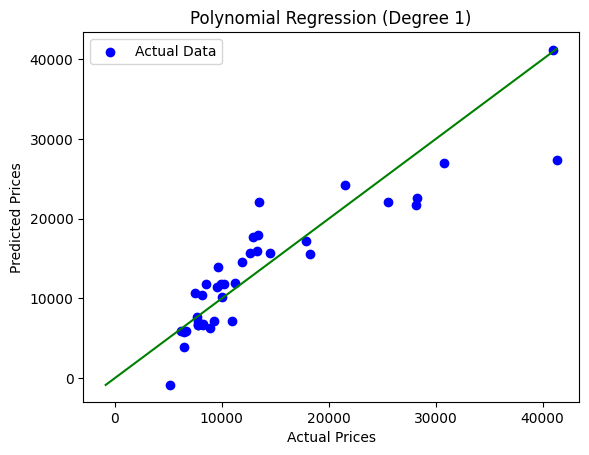

Degree: 2
Mean Squared Error: 14209161.92
R^2 Score: 0.8200



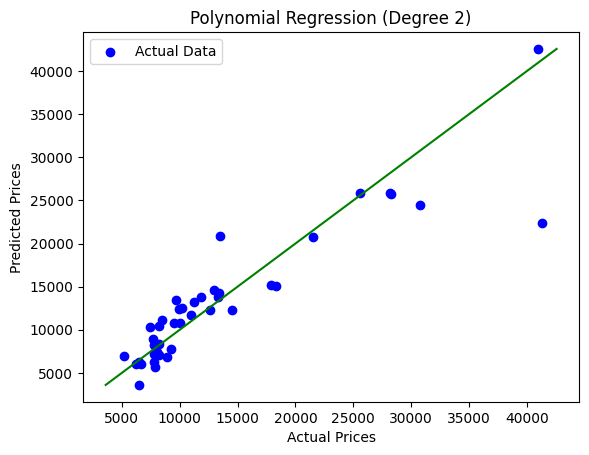

Degree: 3
Mean Squared Error: 961691843.58
R^2 Score: -11.1819



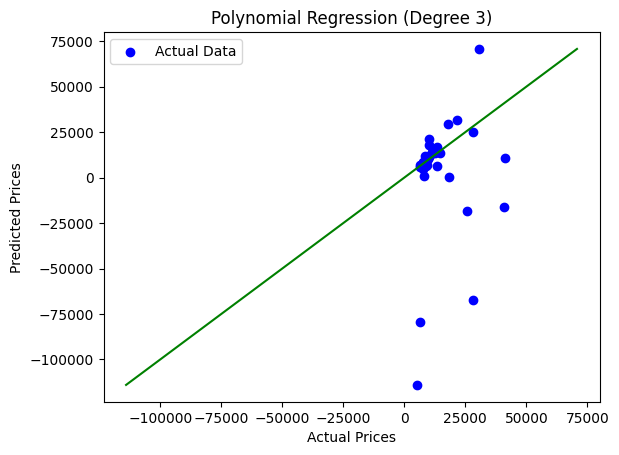

Degree: 4
Mean Squared Error: 4193701945.66
R^2 Score: -52.1225



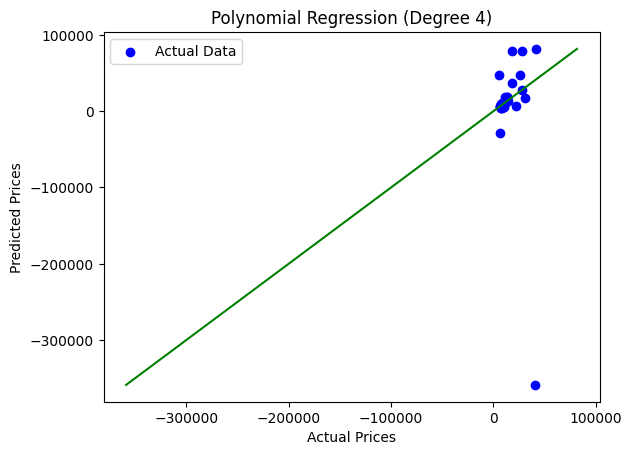

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = [1, 2, 3, 4]
for p in poly:
    poly_features = PolynomialFeatures(degree=p)
    X_poly = poly_features.fit_transform(X_train)

    model = LinearRegression()
    model.fit(X_poly, y_train)

    test_poly = poly_features.transform(X_test)

    y_pred = model.predict(test_poly)

    from sklearn.metrics import mean_squared_error, r2_score

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Degree: {p}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.4f}\n")
    plt.scatter(y_test, y_pred, color="blue", label="Actual Data")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color="green")
    plt.title(f"Polynomial Regression (Degree {p})")
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.legend()
    plt.show()